<br>
<br>
<center> <font size = 6> Monthly Stock Analysis </font> </center>
<br>
<br>
<center> <font size = 3> Last Updated: 10/01-2023 </font> </center>

## Packages 

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import gmean
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import collections as matcoll
import scipy.stats as sps
import math
from datetime import datetime
from PDF_wrapper import *

# RECOMMENDED IMPORTS FOR PROJECTS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from arch import arch_model

# Modules for API calls
import requests
import csv

In [9]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

## Downloading Stock Data 

At first, we have to specify the relevant tickers for the analysis.

In [47]:
TICKERS = [
    "^OMXC25", # OMX Copenhagen 25 Index (25 most traded listed companies as measured by volume)
    "^GSPC"
]

Then we can download the data using the package 'yfinance'.

In [48]:
START = "2017-01-01"

date = datetime.now()
day = date.day
month = date.month
year = date.year

END = str(year) + "-" + str(month) + "-" + str(day)

INTERVAL = "1wk"
stock_data = yf.download(
    tickers = TICKERS,
    start = START,
    end = END,
    interval = INTERVAL
).dropna()['Adj Close']
stock_data = pd.DataFrame(stock_data)

[*********************100%%**********************]  2 of 2 completed


In [49]:
stock_data

,^GSPC,^OMXC25
Date,,
2017-01-01,2276.979980,1037.589966
2017-01-08,2274.639893,1039.680054
2017-01-15,2271.310059,1033.489990
2017-01-22,2294.689941,1052.619995
2017-01-29,2297.419922,1060.790039
...,...,...
2023-10-01,4308.500000,1676.849976
2023-10-08,4327.779785,1699.109985
2023-10-15,4224.160156,1611.959961


## Downloading Data from *Statistikbanken.dk*

In [50]:
url = "https://api.statbank.dk/v1/data"

En komplet beskrivelse af Statistikbankens API kan findes på følgende link: https://www.dst.dk/da/Statistik/brug-statistikken/muligheder-i-statistikbanken/api#metadataogdata

JSON-objektet til POST requesten kan genereres her: https://api.statbank.dk/console#data

I første omgang henter vi data fra Statistikbankens PRIS111, som indeholder inflationsdata fra 2001M01 og frem efter.

In [51]:
MONTH = str(stock_data.index[0].month)
if len(MONTH) == 1:
    MONTH = '0' + MONTH
YEAR = stock_data.index[0].year

postData = {
   "table": "PRIS111",
   "format": "CSV",
   "delimiter": "Semicolon",
   "variables": [
      {
         "code": "ENHED",
         "values": [
            "100",
            #"200",
            #"300"
         ]
      },
      {
         "code": "VAREGR",
         "values": [
            "000000"
         ]
      },
      {
         "code": "Tid",
         "values": [
            ">={}M{}".format(YEAR, MONTH)
         ]
      }
   ]
}

Data bliver returneret som UTF-8. Det er specificeret, at der skal være ";" til at separarere linjerne.

In [52]:
response = requests.post(url, json = postData).content.decode('utf-8-sig')
CSV_readable = response.splitlines()

CPI_Denmark = []
yearMonth = []

for line in CSV_readable[1:]:
    lineData = line.split(';')
    CPI_Denmark.append(float(lineData[-1].replace(",", ".")))
    yearMonth.append(lineData[-2])
    
CPI_Denmark = np.array(CPI_Denmark)
CPI_Denmark = np.around((CPI_Denmark/CPI_Denmark[0])*100,1)
CPI_yearMonth = np.array(yearMonth)

Nu kan vi justere indekskursen, så det svarer til januar 2017-priser. Først skal vi intrapolere CPI-indekset.

In [53]:
EXTENDED_CPI_Denmark = np.zeros(stock_data.shape[0])

counter = 0
extended_index = 0
weeks_in_month = 0
previousMonth = stock_data.index.month[0]
k = 0
total_measures = 0

for index in stock_data.index:
    
    observationDay = index.day
    observationMonth = index.month
    observationYear = index.year
    
    total_measures += 1
    endOfDataFrame = (total_measures == len(stock_data.index))
    
    if observationMonth == ((previousMonth % 12) + 1) or endOfDataFrame:
        
        if endOfDataFrame:
            weeks_in_month += 1 # Otherwise it is not assigned in last iteration
        
        t1_CPI = CPI_Denmark[min(counter + 1, len(CPI_Denmark)-1)]
        t_CPI = CPI_Denmark[min(counter, len(CPI_Denmark)-1)]
         
        increment = (t1_CPI - t_CPI)/weeks_in_month
        
        for i in range(weeks_in_month):
                
            EXTENDED_CPI_Denmark[extended_index] = round(t_CPI + i*increment, 1)
            extended_index += 1
            
                  
        weeks_in_month = 1 # The first week has already been observed
        previousMonth = observationMonth
        counter += 1 # Go to next month's CPI data
        
        
    else:
        weeks_in_month += 1
        

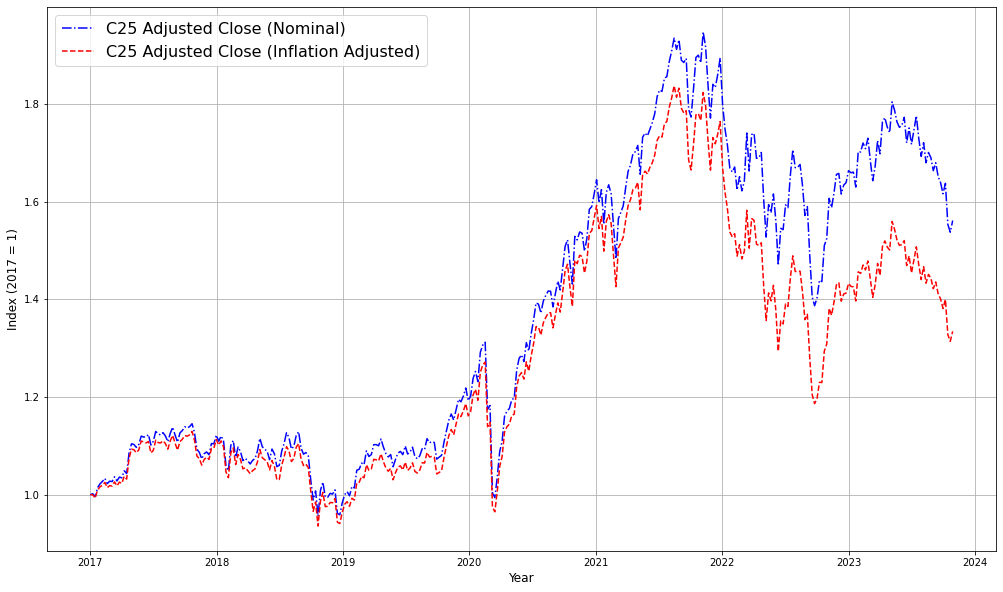

In [59]:
DATA_A = stock_data['^GSPC'].values
DATA_A = DATA_A/DATA_A[0]

DATA_iA = (stock_data['^GSPC'].values / EXTENDED_CPI_Denmark) * 100
DATA_iA = DATA_iA/DATA_iA[0]

DATA_B = stock_data['^OMXC25'].values
DATA_B = DATA_B/DATA_B[0]

DATA_iB = (stock_data['^OMXC25'].values / EXTENDED_CPI_Denmark) * 100
DATA_iB = DATA_iB/DATA_iB[0]


plt.figure(figsize=(17,10))
#plt.plot(stock_data.index, DATA_A, color='b', label='S&P500 Adjusted Close (Nominal)')
#plt.plot(stock_data.index, DATA_iA, color='r', label='S&P500 Adjusted Close (Inflation Adjusted)')
plt.plot(stock_data.index, DATA_B, color='b', linestyle='-.', label='C25 Adjusted Close (Nominal)')
plt.plot(stock_data.index, DATA_iB, color='r', linestyle='dashed', label='C25 Adjusted Close (Inflation Adjusted)')
#plt.title(r'Indices in Weekly Adjusted Closing Price',fontsize=30)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Index (2017 = 1)', fontsize=12)
plt.grid()
plt.legend(fontsize=16, loc='upper left')
plt.savefig('./assets/Indices_inflation_adjusted.png', dpi=400)
plt.show()
